# **DistilBERT Multilabel Training**
# **Link: https://www.kaggle.com/code/samson22/distilbert-in-pytorch**


# **Data Format:**
# **Columns: Text, Labels**
## **Text: tuple of strings - Representing the context**
## **Tuple length 2 -> Context 2**
## **Tuple length 3 -> Context 3**
## **...**
## **Label: tuple of labels - Representing the multilabel classification**

|       TEXT       |   LABEL   | 
|------------------|-----------|
| (TEXT_1, TEXT_2) |  (LABEL_1, LABEL_2, ...)  |
| (TEXT_1, TEXT_2) |  (LABEL_1, LABEL_3, ...)  |
| (TEXT_1, TEXT_2) |  (LABEL_3)                |

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import pandas as pd
csv_path = ""
df = pd.read_csv(csv_path)
df.columns = ['text', 'label']
df.label = df.label.apply(lambda x: (x,))
df.head()

In [ ]:
df.label.value_counts()

# **Processing Labels**
# **Example: (label_1, label_3) -> (1, 0, 1)**
# **Transform labels to use in the Pytorch Model**

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

def labelsPreprocessing(labels):
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    return labels, mlb

labels, encoder = labelsPreprocessing(list(df.label.values))
df.label = list(map(lambda x: tuple(x), labels))
df.label.value_counts()

In [ ]:
import random

def reduceData(df, n=10000000):
    dic = df.groupby(by="label").groups
    selected_texts = []
    selected_labels = []
    selected_id = []
    for k in dic.keys():
        if (len(dic[k]) > n):
            dic[k] = random.sample(list(dic[k]), n)
        for i in dic[k]:
            selected_labels.append(k)
            selected_texts.append(df.text[i])
    return pd.DataFrame(data={"text": selected_texts, "label": selected_labels})

df = reduceData(df, 100)
df.label.value_counts()

# **Model Configuration - Pytorch**

In [ ]:
!pip install torch
!pip install transformers

In [ ]:
import numpy as np
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig

# **Select the hardware to training the pytorch model**

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu' # CPU OR GPU

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Distilbert Tokenizer

# **Data Configuration to Pytorch Model Input**

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        # Class Attributes
        self.tokenizer = tokenizer # Tokenizer
        self.data = dataframe # All Data
        self.text = dataframe.text # Select text column
        self.label = self.data.label # Labels
        self.max_len = max_len # Max length of token list

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        
        # Build a context with sentences
        
        t = self.text[index] # Tuple (sentence_1, sentence_2, sentence_3)
        token_text = "[SEP]".join(t) + "[SEP]" # Join sentences
        final_text = "[CLS]" + token_text # Put [CLS] token at the beginning of the sentence 
            
        inputs = tokenizer.encode_plus(
            final_text, # Text with special tokens ([CLS] and )
            None,
            add_special_tokens=False, # [CLS] and [SEP]
            max_length=self.max_len, # Select Max Length
            pad_to_max_length=True, # Complete Padding with ZEROS
            return_token_type_ids=None, # Token Type Ids -> Identify sentences separated by [SEP] token
            truncation=True
        )
        
        # Ids = TOKEN IDS
        ids = inputs['input_ids']
        # MASK = MASK of words if you are using
        mask = inputs['attention_mask']
        
        # Format the output for the model training
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'label': torch.tensor(self.label[index], dtype=torch.float),
            'sentence': final_text
        }

# **Data Configuration To Pytorch**

In [ ]:
from sklearn.model_selection import train_test_split

# Split dataset according to LABEL column
train_dataset, test_dataset = train_test_split(df, test_size = 0.2, stratify=df['label'])
train_dataset = train_dataset.reset_index().drop(columns=["index"], axis=1)
test_dataset = test_dataset.reset_index().drop(columns=["index"], axis=1)

# **Dataset Shapes - full, train and test**

In [ ]:
print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

MAX_LEN = 512 # Tokens Length
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Distilbert Tokenizer

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

# **Train and Test Parameters**

In [ ]:
TRAIN_BATCH_SIZE = 8 # Train Batch Size
VALID_BATCH_SIZE = 4 # Valid Batch Size

train_params = {
    'batch_size': TRAIN_BATCH_SIZE,           
    'shuffle': True,           
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

# **Build DistilBERT Model**

In [ ]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self, config):
        super(DistilBERTClass, self).__init__()
        self.distilbert = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased') # Load Distilbert Layer
        self.pre_classifier = torch.nn.Linear(config.hidden_size, config.hidden_size) # Bert Pre-classifier
        self.dropout = torch.nn.Dropout(config.dropout) # Dropout
        self.classifier = torch.nn.Linear(config.hidden_size, config.num_labels) # Output Layer. WARNING: 2 is equal to the number of classes (YOU CAN CHANGE THAT)
    
    # Build Foward Order
    
    def forward(self, ids, mask):
        output_1 = self.distilbert(input_ids = ids, attention_mask = mask)
        output_1 = output_1[0] 
        output_1 = output_1[:, 0]                
        output_2 = self.pre_classifier(output_1)
        output_3 = torch.nn.ReLU()(output_2)
        output_4 = self.dropout(output_3)
        output_5 = self.classifier(output_4)
        return output_5


NUM_LABELS = len(test_dataset.label.values[0])
config = DistilBertConfig(vocab_size_or_config_json_file=32000, hidden_size=768, dropout=0.1, num_labels=NUM_LABELS,
        num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072)


model = DistilBERTClass(config)
model.to(device) # Choose the device (CPU or GPU)

# **Training DistilBERT Model**

In [ ]:
import copy

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_labels, num_epochs=2):
    model.train()
    since = time.time()
    print('starting')
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            beta_score_accuracy = 0.0
            
            micro_roc_auc_acc = 0.0
            
            
            # Iterate over data.
            for _,data in enumerate(dataloaders_dict[phase], 0):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                labels = data['label'].to(device, dtype = torch.float)
                
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(ids, mask)
                    
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * ids.size(0)
                
                micro_roc_auc_acc +=  accuracy_thresh(outputs.view(-1,num_labels), labels.view(-1,num_labels))

                
            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_micro_roc_acc = micro_roc_auc_acc / dataset_sizes[phase]

            print('{} total loss: {:.4f} '.format(phase,epoch_loss ))
            print('{} micro_roc_auc_acc: {:.4f}'.format( phase, epoch_micro_roc_acc))

            if phase == 'val' and epoch_loss < best_loss:
                print('saving with loss of {}'.format(epoch_loss), 'improved over previous {}'.format(best_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'distilbert_model_weights.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(float(best_loss)))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
dataloaders_dict = {
    'train': training_loader,
    'val':testing_loader
}

dataset_sizes = {
    'train':train_dataset.shape[0],
    'val':test_dataset.shape[0]
}

In [ ]:
def accuracy_thresh(y_pred, y_true, thresh:float=0.4, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
    return np.mean(((y_pred>thresh).float()==y_true.float()).float().cpu().numpy(), axis=1).sum()

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
from torch.optim import lr_scheduler
import time

criterion = torch.nn.BCEWithLogitsLoss() # Loss Function
EPOCHS = 10 # Epochs
LEARNING_RATE = 1e-05 # Learning Rate

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
model = train_model(model, criterion, optimizer, exp_lr_scheduler, NUM_LABELS, num_epochs=EPOCHS)

# **Predict Test Data - Model**

In [ ]:
def validation():
    model.eval()
    fin_targets = []
    fin_outputs = []
    sentences = []
    annotation_ids = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long) # Tokens
            mask = data['mask'].to(device, dtype = torch.long) # Masks
            targets = data['label'].to(device, dtype = torch.float) # True Label
            outputs = model(ids, mask) # Predict
            # Prepare Output in lists
            sentences.extend(data['sentence']) # predicted texts
            fin_targets.extend(targets.cpu().detach().numpy().tolist())  # true labels of predicted texts
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())  # predicted labels of predicted texts
    return fin_outputs, fin_targets, sentences # Output, True Label, Sentences, IDS

In [ ]:
y_pred, y_test, sentences = validation()
len(y_pred), len(y_test), len(sentences)

# **Evaluate Model**
# **Transform Predictions:**
- ## **Output Model (Probability): (0.18, 0.40, 0.55, 0.88, 0.01)**
- ## **Output Transformed With Threshold == 0.5: (0, 0, 1, 1, 0)**
- ## **Output Transformed With Threshold == 0.6: (0, 0, 0, 1, 0)**
- ## **Output Transformed With Threshold == 0.3: (0, 1, 1, 1, 0)**

In [ ]:
def transformPredictions(threshold, pred):
    r = []
    for e in pred:
        nt = ()
        for p in e:
            nt += (1 if p > threshold else 0,)
        r.append(nt)
    return r
       
y_pred_t = transformPredictions(0.5, y_pred)
y_test = list(map(tuple, y_test))

# **Model Metrics**
## **Hamming Score and Hamming Loss: appropriate for multilabel problem**
## **falsePositives() function: considers all test data**

In [ ]:
from sklearn.metrics import hamming_loss, accuracy_score, multilabel_confusion_matrix, f1_score, plot_confusion_matrix, precision_score, recall_score
import numpy as np

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        # print('\nset_true: {0}'.format(set_true))
        # print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

# Calculate False Positives
def falsePositive(y_true, y_pred):
    total = 0
    fp = 0
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            if (y_pred[i][j] == 1 and y_true[i][j] == 0):
                fp += 1
                break
        total += 1
    return fp/float(total)    


# Show Model Metrics
print("Accuracy Score:", accuracy_score(y_test, y_pred_t))
print("Precision Micro:", precision_score(y_test, y_pred_t, average='micro'))
print("Precision Macro:", precision_score(y_test, y_pred_t, average='macro'))
print("Recall Micro:", recall_score(y_test, y_pred_t, average='micro'))
print("Recall Macro:", recall_score(y_test, y_pred_t,average='macro'))
print("Hamming Score:", hamming_score(np.array(y_test), y_pred_t))
print("Hamming Loss:", hamming_loss(y_test, y_pred_t))
print("F1-Score Micro:", f1_score(y_test, y_pred_t, average='micro'))
print("F1-Score Macro:", f1_score(y_test, y_pred_t, average='macro'))
print("False Positives:", falsePositive(y_test, y_pred_t))

# Build Confusion Matrix
cms = multilabel_confusion_matrix(y_test, y_pred_t)

# **Plot Confusion Matrix - SNS Heatmap**

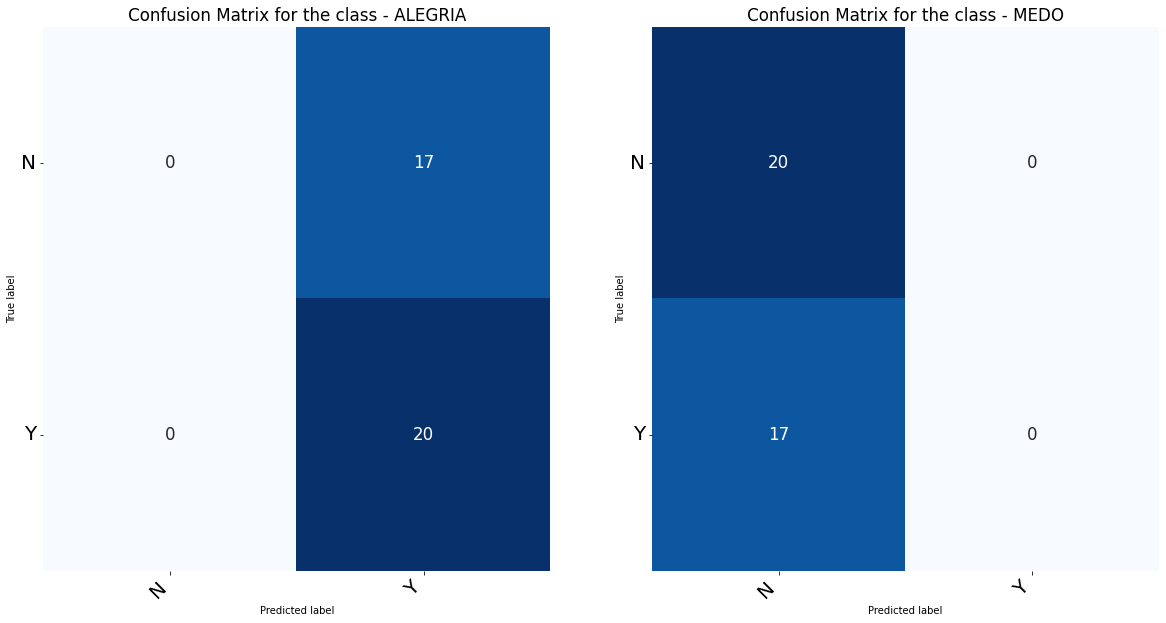

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=20):

    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    sns.set(font_scale=1.4)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap='Blues')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

def plotMultiLabelConfusionMatrices(cms, labels):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for axes, conf_matrix, label in zip(ax.flatten(), cms, labels):
        print_confusion_matrix(conf_matrix, axes, label, ["N", "Y"])
        
labels = ['ALEGRIA', 'MEDO'] # Labels in alphabetic order
plotMultiLabelConfusionMatrices(cms, labels)

# Saving Model

In [ ]:
path = "" # Path Of Model
torch.save(model.state_dict(), path)